/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.7761 - loss: 0.9589 - val_accuracy: 0.9393 - val_loss: 0.3606
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 19ms/step - accuracy: 0.9235 - loss: 0.4059 - val_accuracy: 0.9659 - val_loss: 0.2339
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9550 - loss: 0.2778 - val_accuracy: 0.9747 - val_loss: 0.1943
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9614 - loss: 0.2473 - val_accuracy: 0.9768 - val_loss: 0.1853
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9629 - loss: 0.2336 - val_accuracy: 0.9771 - val_loss: 0.1790
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9632 - loss: 0.2248 - val_accuracy: 0.9782 - val_loss: 0.1751
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - accuracy: 0.9686 - loss: 0.2135 - val_accuracy: 0.9787 - val_loss: 0.1709
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.9649 -

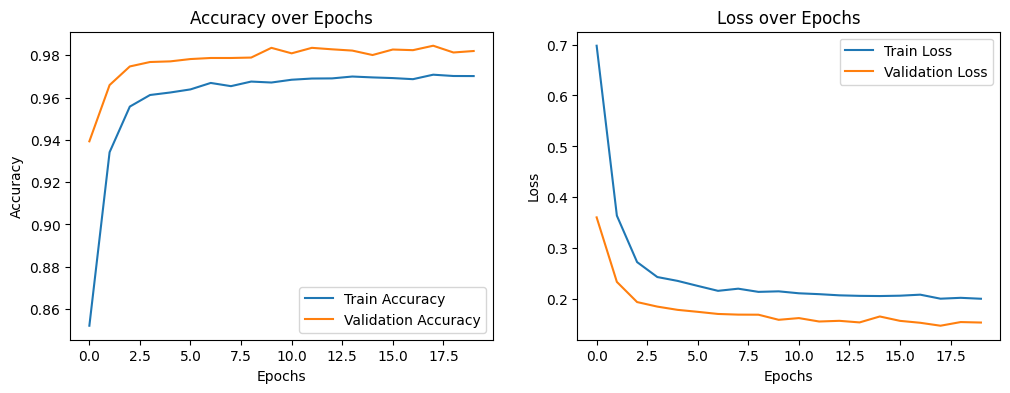

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


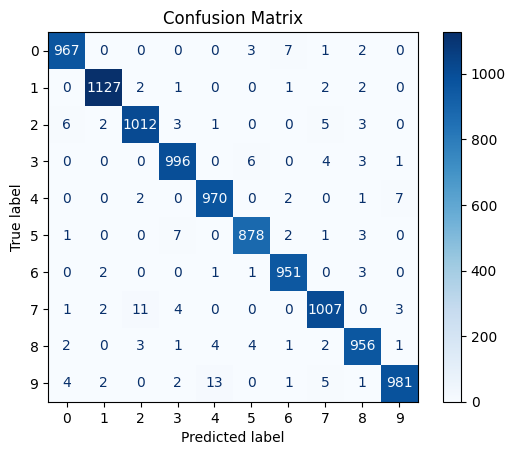

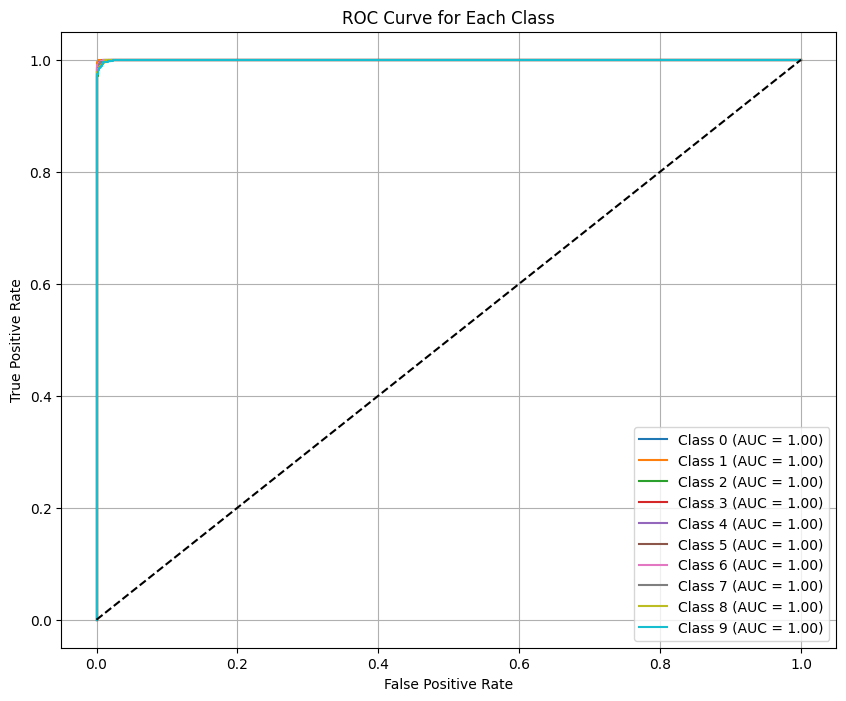

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9850 - loss: 0.1470
Test accuracy: 0.984499990940094


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import tensorflow_datasets as tfds

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# Normalize the pixel values to [0, 1]
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).cache().prefetch(tf.data.AUTOTUNE)

# Build the LeNet-5 model with Dropout and L2 Regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1), kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),  # Add Dropout for regularization
    tf.keras.layers.Dense(units=84, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),  # Add Dropout for regularization
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    ds_train,
    epochs=20,  # Increase the number of epochs
    validation_data=ds_test,
    callbacks=[early_stopping]  # Use Early Stopping
)

# Plotting Accuracy and Loss Curves
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model and get predictions
y_true = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_pred_prob = model.predict(ds_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve (for each class)
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test accuracy: {test_acc}")
